# Time Series Forecasting on NYC_Taxi

w MLFlow

- Objectives
  - Leverage ML FLow to build some time series models

- Simple Forecast of aggregate daily data to start
- Later will need to look at splitting out the datasets into different spots

In [3]:
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 364 µs (started: 2021-07-24 13:54:42 +00:00)


In [4]:
import os
from pyspark.sql import SparkSession
packages="""io.delta:delta-core_2.12:1.0.0,org.apache.hadoop:hadoop-aws:3.2.0"""
os.environ['PYSPARK_SUBMIT_ARGS'] = "--packages io.delta:delta-core_2.12:1.0.0,org.apache.hadoop:hadoop-aws:3.2.0 pyspark-shell"

time: 118 ms (started: 2021-07-24 13:54:42 +00:00)


In [9]:
from pyspark.sql import functions as F

time: 3.01 ms (started: 2021-07-24 13:54:58 +00:00)


In [5]:
spark = SparkSession \
            .builder \
            .config("spark.executor.cores", 4) \
            .config("spark.executor.memory", "4g") \
            .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
            .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
            .config("spark.master", "spark://spark-master:7077") \
            .config("spark.hadoop.fs.s3a.access.key", os.environ['MINIO_ACCESS_KEY']) \
            .config("spark.hadoop.fs.s3a.secret.key", os.environ['MINIO_SECRET_KEY']) \
            .config("spark.hadoop.fs.s3a.endpoint", "minio:9000") \
            .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "false") \
            .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
            .config("spark.hadoop.metastore.catalog.default", "hive") \
            .config("spark.sql.warehouse.dir", "s3a://storage/warehouse") \
            .config("spark.hadoop.fs.s3a.path.style.access", "true") \
            .config("spark.hadoop.fs.s3a.connection.maximum", "50") \
            .config("spark.hive.metastore.uris", "thrift://192.168.64.4:9083") \
            .appName("Jupyter Time Series") \
            .enableHiveSupport() \
            .getOrCreate()

time: 3.29 s (started: 2021-07-24 13:54:43 +00:00)


In [6]:
# tuning settings spark.sql.shuffle.partitions to match with core settings
# not tuned for file size yet

# set to cores to increase the efficiency
spark.conf.set("spark.sql.shuffle.partitions", spark.sparkContext.defaultParallelism*4)

## faster pandas data transfers
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

time: 4.27 ms (started: 2021-07-24 13:54:46 +00:00)


In [32]:
from tseries.taxi_daily import TaxiDaily

time: 1.27 ms (started: 2021-07-24 14:50:33 +00:00)


In [34]:
taxi_daily = TaxiDaily(spark)
taxi_daily.load_data()

time: 141 ms (started: 2021-07-24 14:51:14 +00:00)


In [42]:
taxi_daily.train_data.agg(F.min(F.col('ds')), F.max(F.col('ds'))).collect()

[Row(min(ds)=datetime.date(2013, 8, 1), max(ds)=datetime.date(2014, 6, 30))]

time: 9.13 s (started: 2021-07-24 14:57:06 +00:00)


In [43]:
taxi_daily.test_data.agg(F.min(F.col('ds')), F.max(F.col('ds'))).collect()

[Row(min(ds)=datetime.date(2014, 7, 1), max(ds)=datetime.date(2015, 6, 30))]

time: 8.01 s (started: 2021-07-24 14:57:18 +00:00)


## Forecasting the Dataframe

In [15]:
# credentials for storing our model artifacts
# mlflow needs these to be set whenever it is being called
os.environ['AWS_ACCESS_KEY_ID'] = os.environ.get('MINIO_ACCESS_KEY')
os.environ['AWS_SECRET_ACCESS_KEY'] = os.environ.get('MINIO_SECRET_KEY')
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://minio:9000'

time: 519 µs (started: 2021-07-24 13:55:28 +00:00)


In [16]:
import prophet
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import mlflow

time: 1.77 s (started: 2021-07-24 13:55:28 +00:00)


There was an error in the hostname resolution hence switch to ip

In [17]:
#mlflow.delete_experiment(1)

time: 151 µs (started: 2021-07-24 13:55:29 +00:00)


In [18]:
mlflow.set_tracking_uri("http://192.168.64.21:5000/")
tracking_uri = mlflow.get_tracking_uri()
print("Current tracking uri: {}".format(tracking_uri))

Current tracking uri: http://192.168.64.21:5000/
time: 8.45 ms (started: 2021-07-24 13:55:29 +00:00)


In [19]:
### Quick test on creating experiments
from mlflow.exceptions import RestException

try:
    mlflow.create_experiment(
        name='taxi_daily_forecast'
    )
except RestException:
    print('already_created')

already_created
time: 363 ms (started: 2021-07-24 13:55:29 +00:00)


In [20]:
experiment = mlflow.get_experiment(15)
experiment.artifact_location

's3://mlflow/15'

time: 20.2 ms (started: 2021-07-24 13:55:30 +00:00)


In [21]:
# Build an evaluation function
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

time: 165 ms (started: 2021-07-24 13:55:30 +00:00)


In [22]:
# To save models to mlflow we need to write a python wrapper 
# to make sure that it performs as mlflow expects
import mlflow.pyfunc

class ProphetModel(mlflow.pyfunc.PythonModel):
    
    def __init__(self, model):
        
        self.model = model
        super().__init__()
        
    def load_context(self, context):
        from prophet import Prophet
        return
    
    def predict(self, context, model_input):
        future = self.model.make_future_dataframe(periods=model_input['periods'][0])
        return self.model.predict(future)

time: 357 µs (started: 2021-07-24 13:55:30 +00:00)


44 seconds for training by default \
3.62 seconds with processes parallelisation \
13 seconds after we add the toPandas conversion here and run with parallelisation

In [44]:
%time

rolling_window = 0.1

conda_env = {
    'channels': ['conda-forge'],
    'dependencies': [{
        'pip': [
            'prophet=={0}'.format(prophet.__version__)
        ]
    }],
    "name": "prophetenv"
}

with mlflow.start_run(experiment_id=15):
    m = prophet.Prophet(daily_seasonality=True)
    m.fit(taxi_daily.train_data.toPandas())
    
    # cross validation is the thingy that is generating our different train sets
    # tqdm is glitchy with my setup so disabling for now
    df_cv = cross_validation(m, initial="28 days", period="7 days", horizon="14 days", 
                                 disable_tqdm=True, parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=rolling_window)
    
    mlflow.log_param("rolling_window", rolling_window)
    mlflow.log_metric("rmse", df_p.loc[0, "rmse"])
    mlflow.log_metric("mae", df_p.loc[0, "mae"])
    mlflow.log_metric("mape", df_p.loc[0, "mape"])
    
    print("  CV: {}".format(df_cv.head()))
    print("  Perf: {}".format(df_p.head()))
    
    mlflow.pyfunc.log_model("model", conda_env=conda_env, python_model=ProphetModel(m))
    print(
            "Logged model with URI: runs:/{run_id}/model".format(
                run_id=mlflow.active_run().info.run_id
            )
        )

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Making 42 forecasts with cutoffs between 2013-09-02 00:00:00 and 2014-06-16 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fa74bb6a3d0>


  CV:           ds           yhat     yhat_lower     yhat_upper       y     cutoff
0 2013-09-03  501585.281837  429703.734993  577125.672144  423109 2013-09-02
1 2013-09-04  518817.592943  451436.128334  592961.072427  454753 2013-09-02
2 2013-09-05  504761.734693  428236.807425  580441.344052  468204 2013-09-02
3 2013-09-06  495324.421080  418633.670612  562535.009924  509666 2013-09-02
4 2013-09-07  474445.011476  399711.927957  549764.459063  512373 2013-09-02
  Perf:   horizon           mse          rmse           mae      mape     mdape  \
0  2 days  2.802909e+09  52942.502951  37278.418974  0.086742  0.049990   
1  3 days  3.124219e+09  55894.709955  37167.961699  0.085093  0.047995   
2  4 days  3.170948e+09  56311.167889  37426.567206  0.081971  0.043602   
3  5 days  2.723070e+09  52183.046660  38084.927978  0.074821  0.056177   
4  6 days  1.912054e+09  43727.040544  33739.912505  0.068865  0.045557   

      smape  coverage  
0  0.078420  0.885057  
1  0.077513  0.887521  
2

# Prophet Diagnostics

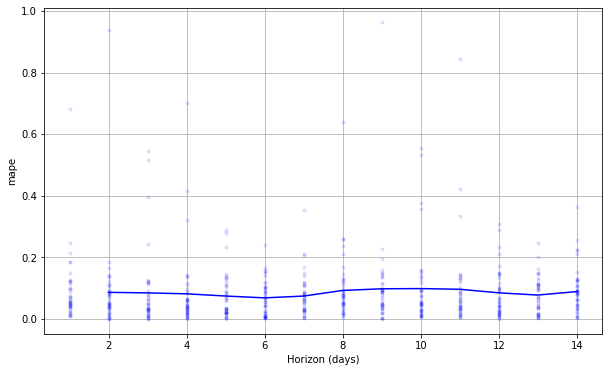

time: 98.7 ms (started: 2021-07-24 14:59:08 +00:00)


In [45]:
# Python
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

We aren't seeing many differences with longer horizons

In [46]:
future = m.make_future_dataframe(periods=len(taxi_daily.test_data.toPandas()))

time: 8.6 s (started: 2021-07-24 15:01:26 +00:00)


In [47]:
forecast = m.predict(future)

time: 3.57 s (started: 2021-07-24 15:01:46 +00:00)


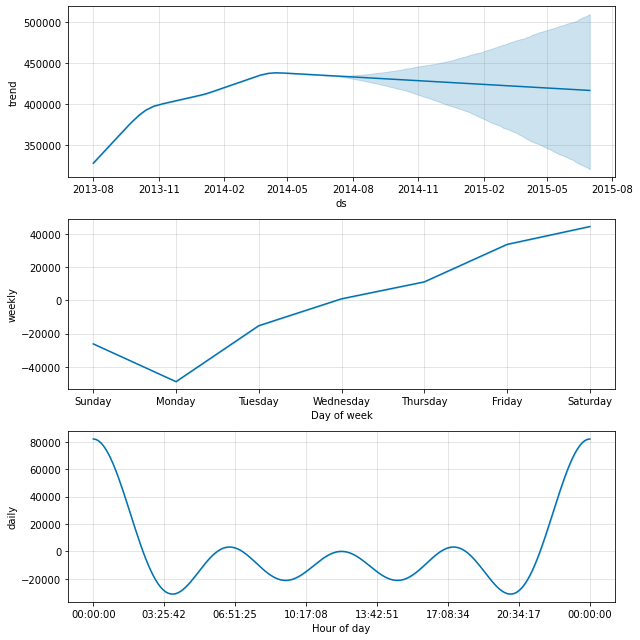

time: 387 ms (started: 2021-07-24 15:03:21 +00:00)


In [49]:
fig = m.plot_components(forecast)

# Testing out Uber Orbit

In [50]:
from orbit.models.dlt import DLTFull
from orbit.diagnostics.plot import plot_predicted_data

time: 308 ms (started: 2021-07-24 15:07:46 +00:00)


In [53]:
dlt = DLTFull(
    response_col='y', date_col='ds',
    #regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    seasonality=7,
)

time: 541 µs (started: 2021-07-24 15:09:29 +00:00)


In [54]:
dlt.fit(df=taxi_daily.train_data.toPandas())

# outcomes data frame
predicted_df = dlt.predict(df=taxi_daily.test_data.toPandas())

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b0a449c7523386cce384e92a998e71c8 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


time: 59 s (started: 2021-07-24 15:09:31 +00:00)


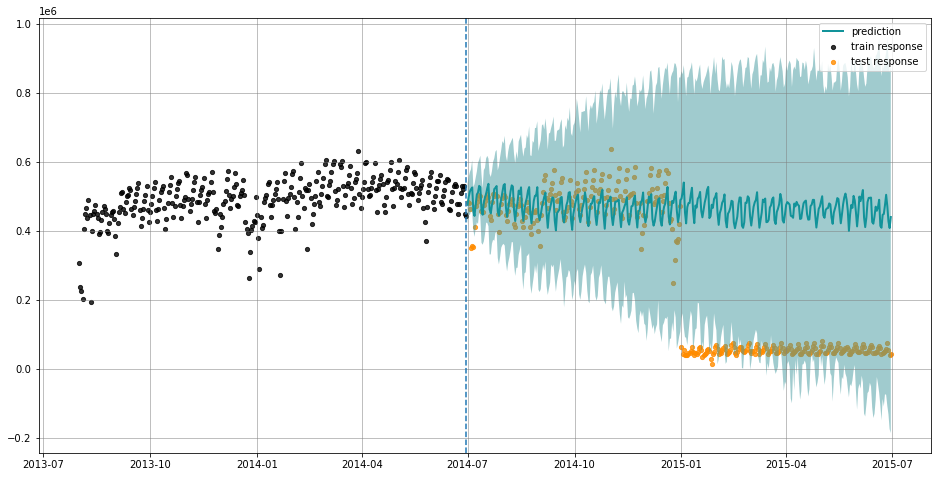

<AxesSubplot:>

time: 17.7 s (started: 2021-07-24 15:10:39 +00:00)


In [55]:
plot_predicted_data(
    training_actual_df=taxi_daily.train_data.toPandas(), predicted_df=predicted_df,
    date_col=dlt.date_col, actual_col=dlt.response_col,
    test_actual_df=taxi_daily.test_data.toPandas()
)